LBP+SVM

E:\Anaconda\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
E:\Anaconda\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Classification Report (Balanced):
              precision    recall  f1-score   support

 Agriculture       0.39      0.41      0.40       171
     Airport       0.37      0.38      0.38       158
       Beach       0.58      0.51      0.54       169
        City       0.52      0.40      0.45       166
      Desert       0.54      0.54      0.54       158
      Forest       0.68      0.80      0.74       143
   Grassland       0.72      0.64      0.68       167
     Highway       0.56      0.53      0.54       158
        Lake       0.48      0.36      0.41       154
    Mountain       0.49      0.64      0.55       162
     Parking       0.67      0.64      0.65       171
        Port       0.61      0.61      0.61       155
     Railway       0.52      0.55      0.53       164
 Residential       0.53      0.64      0.58       148
       River       0.28      0.29      0.29       156

    accuracy                           0.53      2400
   macro avg       0.53      0.53      0.53   

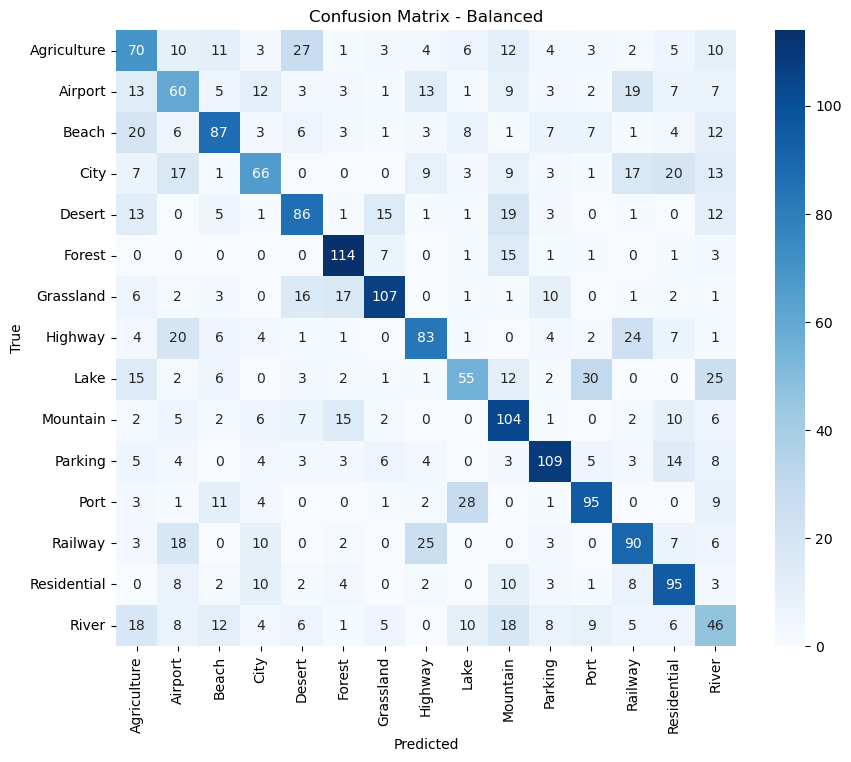

E:\Anaconda\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
E:\Anaconda\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Classification Report (Imbalanced):
              precision    recall  f1-score   support

 Agriculture       0.11      0.01      0.01       171
     Airport       0.00      0.00      0.00       158
       Beach       0.21      0.02      0.04       169
        City       0.04      0.01      0.01       166
      Desert       0.21      0.61      0.31       158
      Forest       0.18      0.76      0.29       143
   Grassland       0.27      0.58      0.37       167
     Highway       0.50      0.01      0.02       158
        Lake       0.39      0.12      0.19       154
    Mountain       0.17      0.74      0.28       162
     Parking       0.00      0.00      0.00       171
        Port       0.55      0.35      0.43       155
     Railway       0.30      0.12      0.17       164
 Residential       0.00      0.00      0.00       148
       River       0.29      0.01      0.02       156

    accuracy                           0.22      2400
   macro avg       0.21      0.22      0.14 

E:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


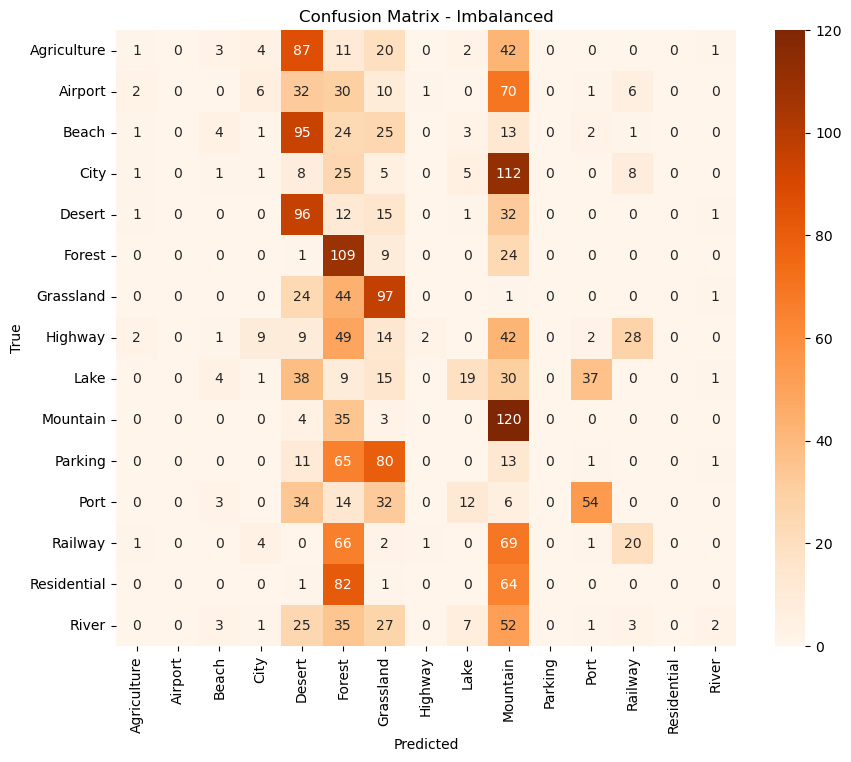

E:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


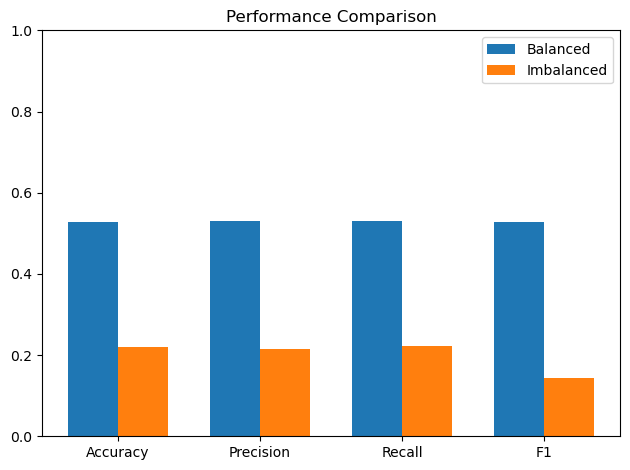

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random

import tensorflow as tf
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern
from skimage.filters import median
from skimage.morphology import disk

from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

# ===================== Parameter Settings =====================
IMG_SIZE = (256, 256)
SEED = 42
RADIUS = 1
N_POINTS = 8 * RADIUS
METHOD = 'uniform'
MEDIAN_DISK_SIZE = 3

SVM_PARAM_DIST = {
    'C': [0.1, 1, 10],
    'gamma': [1e-3, 1e-2, 1e-1],
    'kernel': ['rbf']
}
N_ITER_SEARCH = 10
CV_FOLDS = 5
SAMPLE_RATIO = 0.5

DATASET_DIR = r"D:\\quark download\\9517 Week1 home work\\project\\Aerial_Landscapes"
INDEX_DIR = r"D:\\quark download\\9517 Week1 home work\\project\\preprocess"

# ===================== Load Images by Index =====================
class_names = sorted(os.listdir(DATASET_DIR))
image_paths, labels = [], []
for label_index, class_name in enumerate(class_names):
    class_dir = os.path.join(DATASET_DIR, class_name)
    for file in sorted(os.listdir(class_dir)):
        if file.lower().endswith(".jpg"):
            image_paths.append(os.path.join(class_dir, file))
            labels.append(label_index)
labels = np.array(labels)

train_indices = np.load(os.path.join(INDEX_DIR, 'train_indices.npy'))
val_indices = np.load(os.path.join(INDEX_DIR, 'val_indices.npy'))


def load_images_by_indices(indices):
    X, y = [], []
    for i in indices:
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, IMG_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
        X.append(img)
        y.append(labels[i])
    return np.array(X), np.array(y)


X_train_raw, y_train = load_images_by_indices(train_indices)
X_test_raw, y_test = load_images_by_indices(val_indices)

# ===================== LBP Feature Extraction =====================
def compute_lbp_histogram(image, eps=1e-7):
    denoised = median(image, disk(MEDIAN_DISK_SIZE))
    lbp = local_binary_pattern(denoised, N_POINTS, RADIUS, METHOD)
    n_bins = int(N_POINTS + 2)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    hist = hist.astype("float")
    hist /= (hist.sum() + eps)
    return hist

def extract_lbp_features(images):
    return np.array([compute_lbp_histogram(rgb2gray(img)) for img in images])

X_train_features = extract_lbp_features(X_train_raw)
X_test_features = extract_lbp_features(X_test_raw)

scaler = StandardScaler()
X_train_features_norm = scaler.fit_transform(X_train_features)
X_test_features_norm = scaler.transform(X_test_features)

# ===================== Balanced Training =====================
sample_size = int(len(X_train_features_norm) * SAMPLE_RATIO)
sample_indices = np.random.choice(len(X_train_features_norm), sample_size, replace=False)
X_train_sample = X_train_features_norm[sample_indices]
y_train_sample = y_train[sample_indices]

random_search = RandomizedSearchCV(
    SVC(class_weight='balanced', random_state=SEED),
    param_distributions=SVM_PARAM_DIST,
    n_iter=N_ITER_SEARCH,
    cv=CV_FOLDS,
    scoring='accuracy',
    n_jobs=-1,
    random_state=SEED
)
random_search.fit(X_train_sample, y_train_sample)
best_svm = random_search.best_estimator_
y_pred = best_svm.predict(X_test_features_norm)

# ===================== Evaluation: Balanced =====================
print("Classification Report (Balanced):")
print(classification_report(y_test, y_pred, target_names=class_names))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Balanced")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ===================== Create Imbalanced Dataset + Augment =====================
def augment_image(image):
    augmented = []
    if random.random() < 0.5:
        augmented.append(np.fliplr(image))
    if random.random() < 0.5:
        augmented.append(np.flipud(image))
    if random.random() < 0.5:
        bright = np.clip(image + np.random.uniform(0.1, 0.3), 0, 1)
        augmented.append(bright)
    if random.random() < 0.5:
        contrast = np.clip(image * np.random.uniform(0.7, 1.3), 0, 1)
        augmented.append(contrast)
    if random.random() < 0.5:
        noise = image + np.random.normal(0, 0.03, image.shape)
        augmented.append(np.clip(noise, 0, 1))
    return augmented if augmented else [image]


def create_imbalanced_dataset(X, y, min_count=50):
    unique_classes = np.unique(y)
    new_X, new_y = [], []
    original_count = np.sum(y == unique_classes[0])
    for i, cls in enumerate(sorted(unique_classes)):
        desired = int(round(original_count - i * ((original_count - min_count) / (len(unique_classes) - 1))))
        indices = np.where(y == cls)[0]
        np.random.shuffle(indices)
        selected = indices[:desired]
        for idx in selected:
            new_X.append(compute_lbp_histogram(rgb2gray(X[idx])))
            new_y.append(y[idx])
        if desired < 80:
            for idx in selected:
                for aug in augment_image(X[idx]):
                    new_X.append(compute_lbp_histogram(rgb2gray(aug)))
                    new_y.append(y[idx])
    return np.array(new_X), np.array(new_y)

X_train_imbal, y_train_imbal = create_imbalanced_dataset(X_train_raw, y_train)

# ===================== Imbalanced Training =====================
random_search_imb = RandomizedSearchCV(
    SVC(class_weight='balanced', random_state=SEED),
    param_distributions=SVM_PARAM_DIST,
    n_iter=N_ITER_SEARCH,
    cv=CV_FOLDS,
    scoring='accuracy',
    n_jobs=-1,
    random_state=SEED
)
random_search_imb.fit(X_train_imbal, y_train_imbal)
best_svm_imb = random_search_imb.best_estimator_
y_pred_imbal = best_svm_imb.predict(X_test_features_norm)

# ===================== Evaluation: Imbalanced =====================
print("Classification Report (Imbalanced):")
print(classification_report(y_test, y_pred_imbal, target_names=class_names))
cm_imbal = confusion_matrix(y_test, y_pred_imbal)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_imbal, annot=True, fmt="d", cmap="Oranges", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Imbalanced")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ===================== Performance Comparison =====================
def get_scores(y_true, y_pred):
    return [
        accuracy_score(y_true, y_pred),
        precision_score(y_true, y_pred, average='macro'),
        recall_score(y_true, y_pred, average='macro'),
        f1_score(y_true, y_pred, average='macro')
    ]

scores_bal = get_scores(y_test, y_pred)
scores_imbal = get_scores(y_test, y_pred_imbal)

x = np.arange(4)
labels = ['Accuracy', 'Precision', 'Recall', 'F1']
width = 0.35
plt.bar(x - width/2, scores_bal, width, label='Balanced')
plt.bar(x + width/2, scores_imbal, width, label='Imbalanced')
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.title('Performance Comparison')
plt.legend()
plt.tight_layout()
plt.show()
